# Self-Driving Car Engineer Nanodegree

## **Vehicle detection and tracking** 

![Cover](./writeup_imgs/cover.jpg)

---

## Overview

In this project, your goal is to write a software pipeline to identify vehicles in a video from a front-facing camera on a car. The test images and project video are available in the [project repository](https://github.com/miguelangel/sdc--vehicle-detection-and-tracking). 

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. A great writeup should include the [rubric](https://review.udacity.com/#!/rubrics/513/view) points as well as your description of how you addressed each point. You should include a detailed description of the code used in each step (with line-number references and code snippets where appropriate) and links to other supporting documents or external references. You should also include images in your writeup to illustrate how your code works.


## Goals/Steps

The goals / steps of this project are the following:
* Import and initialize the packages needed in the project.
* Implement a function that computes Histogram of Oriented Gradients (HOG) features from an image.
* Implement a function that computes binned color features from an image.
* Implement a function that computes color histogram features from an image.
* Combine the previous feature extractors on a function
* Extract features from the dataset, and split them in training and testing sets
* Normalize the features 
* Train a Linear SVM classifier.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Step 0: Import and initialize the packages needed in the project

In [1]:
import cv2
import glob
from IPython.display import HTML
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from moviepy.editor import VideoFileClip
import numpy as np
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import time


# My humble tribute to Michael Jordan, 
# the best basketball player ever.
np.random.seed(23)

%matplotlib inline

### Step 1: Implement a function that computes Histogram of Oriented Gradients (HOG) features from an image

In [2]:
# This function returns HOG features and visualization
# Features will always be the first element of the return
# Image data will be returned as the second element if visualize= True
# Otherwise there is no second return element
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """
    Function accepts params and returns HOG features (optionally flattened)
    and an optional matrix for visualization. Features will always be the
    first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    return_list = hog(img, orientations=orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell),
        cells_per_block=(cell_per_block, cell_per_block),
        block_norm='L2-Hys', transform_sqrt=True, 
        visualise=vis, feature_vector=feature_vec)
    
    if vis:
        hog_features = return_list[0]
        hog_image = return_list[1]
        
        return hog_features, hog_image
    else:
        hog_features = return_list
        
        return hog_features

In [3]:
# Helper method to plot two images side by side
def plt_images(img_1, title_1, img_2, title_2, cmap='gray'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.set_title(title_1, fontsize=16)
    ax1.imshow(img_1)
    ax2.set_title(title_2, fontsize=16)
    ax2.imshow(img_2, cmap='gray')

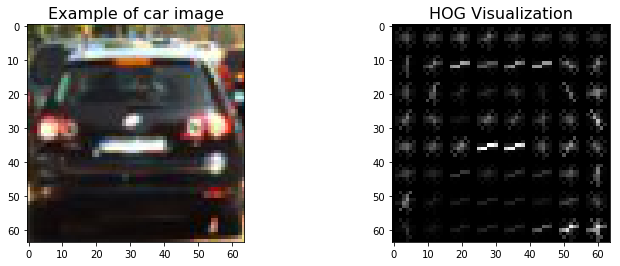

In [4]:
# Run the function on car images
car_images = glob.glob('./data/vehicles_smallset/*/*.jpeg')
#car_images = glob.glob('./data/vehicles/*/*.png')

# Display a random car image and its HOG visualization,
ind = np.random.randint(0, len(car_images))

# Read in the image and convert it to grayscale
car_img = mpimg.imread(car_images[ind])
gray_img = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray_img, orient=9, pix_per_cell=8,
                                    cell_per_block=2, vis=True, feature_vec=False)

# Plot results
plt_images(car_img, 'Example of car image', hog_image, 'HOG Visualization')

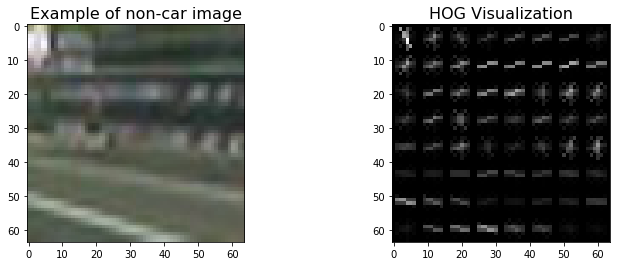

In [5]:
# Run the function also on non-car images
non_car_images = glob.glob('./data/non-vehicles_smallset/*/*.jpeg')
#non_car_images = glob.glob('./data/non-vehicles/*/*.png')

# Display a random car image and its HOG visualization,
ind = np.random.randint(0, len(non_car_images))

# Read in the image and convert it to grayscale
non_car_img = mpimg.imread(non_car_images[ind])
gray_img = cv2.cvtColor(non_car_img, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray_img, orient= 9, pix_per_cell= 8,
                               cell_per_block= 2, vis=True, feature_vec=False)

hog_features = get_hog_features(gray_img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True)


# Plot results
plt_images(non_car_img, 'Example of non-car image', hog_image, 'HOG Visualization')

### Step 2: Implement a function that computes binned color features from an image

In [6]:
# This function computes binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

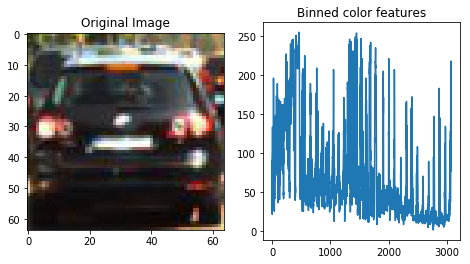

In [7]:
# Run the function
spatial_features = bin_spatial(car_img, size=(32, 32))

# Plot results
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(car_img)
plt.subplot(132)
plt.title('Binned color features')
plt.plot(spatial_features)

### Step 3: Implement a function that computes color histogram features from an image

In [8]:
# This function computes color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

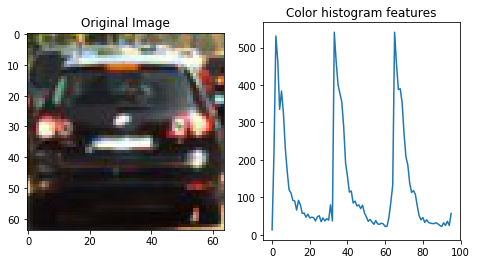

In [9]:
# Run the function
hist_features = color_hist(car_img, nbins=32, bins_range=(0, 256))

# Plot results
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title('Original Image')
plt.imshow(car_img)
plt.subplot(132)
plt.title('Color histogram features')
plt.plot(hist_features)

### Step 4: Combine the previous feature extractors on a function

In [10]:
# This function extracts features from a list of images
def extract_features(imgs, cspace='RGB', orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256),
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        img = mpimg.imread(file)

        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        else: feature_img = np.copy(img)
            
        if spatial_feat == True:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_img, size=spatial_size)

        if hist_feat == True:
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_img, nbins=hist_bins, bins_range=hist_range)

        if hog_feat == True:            
            # Apply get_hog_features() to get hog features
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_img.shape[2]):
                    print("Here")
                    hog_features.append(get_hog_features(feature_img[:, :, channel], 
                                        orient=orient, pix_per_cell=pix_per_cell,
                                        cell_per_block=cell_per_block, 
                                        vis=False, feature_vec=True))

                hog_features = np.ravel(hog_features)        
            else:
                print("There")
                hog_features = get_hog_features(feature_img[:, :, hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    
    # Return list of feature vectors
    return features

### Step 5: Extract features from the dataset, and split them in training and testing sets

In [11]:
# Parameters
cspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
hist_bins = 32
hist_range=(0, 256)

# Extract features from car and non_car datasets
car_features = extract_features(car_images, cspace=cspace, orient=orient,
                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                hog_channel=hog_channel, spatial_size=spatial_size,
                hist_bins=hist_bins, hist_range=hist_range)

non_car_features = extract_features(non_car_images, cspace=cspace, orient=orient,
                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                hog_channel=hog_channel, spatial_size=spatial_size,
                hist_bins=hist_bins, hist_range=hist_range)

# Create features and labels dataset
features = np.vstack((car_features, non_car_features)).astype(np.float64)
car_labels = np.ones(len(car_features))
non_car_labels = np.zeros(len(non_car_features))
labels = np.concatenate((car_labels, non_car_labels))

# Split our dataset in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=23)

# Print the results
print ("The dataset is well balanced:")
print ("- Number of car_images:", len(car_images))
print ("- Number of non_car images:", len(non_car_images))
print ()
print ("Number of samples:")
print ("- In training set:", X_train.shape[0])
print ("- In testing set:", X_test.shape[0])
print ()
print ("X_train before normalization:")
print (X_train)

There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
Ther

There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
There
Ther

### Step 6: Normalize the features

In [12]:
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to both X_train and X_test
X_train = X_scaler.transform(X_train) 
X_test = X_scaler.transform(X_test)

# Print the results
print("X_train after normalization:")
print(X_train)
print()
scaled_features = np.vstack((X_train, X_test))
print("Features mean after normalization: {:.2f}".format(np.mean(scaled_features)))
print("Features variance after normalization: {:.2f}".format(np.var(scaled_features)))


X_train after normalization:
[[ 1.09452993 -0.79219021 -0.56000995 ... -0.38026351 -0.31955965
  -0.3172516 ]
 [ 0.71900094 -0.84579815  0.14584364 ... -0.34877251 -0.08634947
   1.02461519]
 [ 0.71900094 -0.32758804 -0.54191114 ... -0.39359094  0.96014274
   4.66703285]
 ...
 [-0.50146828 -1.07809923 -0.27042899 ... -0.30511355 -0.18571845
  -0.32601901]
 [ 1.2353533  -0.55988913 -0.68670162 ... -0.39359094 -0.31955965
  -0.32601901]
 [-0.73617391 -0.50628118  0.30873293 ... -0.24996632 -0.25861133
   0.32371507]]

Features mean after normalization: 0.00
Features variance after normalization: 1.00


### Step 7: Train a Linear SVM classifier

In [13]:
# Use a linear SVC 
svc = LinearSVC()

# Parameters
parameters = {'C':[0.1, 1, 10]}

# Check the training time for the SVC
t=time.time()
grid = GridSearchCV(svc, parameters)
grid = grid.fit(X_train, y_train)

clf = grid.best_estimator_

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train LinearSVC...')

# Check the score of the SVC
print('Test Accuracy of LinearSVC = ', round(clf.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My LinearSVC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with LinearSVC')
print("Best parameters:", print (grid.best_params_))

2.76 Seconds to train LinearSVC...
Test Accuracy of LinearSVC =  0.9892
My LinearSVC predicts:  [0. 0. 1. 0. 1. 1. 0. 0. 1. 1.]
For these 10 labels:  [0. 0. 1. 0. 1. 1. 0. 0. 1. 1.]
0.00072 Seconds to predict 10 labels with LinearSVC


In [14]:
print (grid.best_params_)

{'C': 0.1}


In [21]:
# Use a linear SVC 
svc = SVC()

parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10]}

# Check the training time for the SVC
t=time.time()
grid = GridSearchCV(svc, parameters)
grid = grid.fit(X_train, y_train)

clf = grid.best_estimator_

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
print("Best parameters:", grid.best_params_)

116.59 Seconds to train SVC...
Test Accuracy of SVC =  0.9849
My SVC predicts:  [0. 0. 1. 0. 1. 1. 0. 0. 1. 1.]
For these 10 labels:  [0. 0. 1. 0. 1. 1. 0. 0. 1. 1.]
0.01033 Seconds to predict 10 labels with SVC
Best parameters: {'C': 10, 'kernel': 'rbf'}


### Step 8: Implement a sliding-window technique and use your trained classifier to search for vehicles in images

In [22]:
# This function draws boxes in an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    
    # Return the image copy with boxes drawn
    return imcopy

# This funciton takes an image, start and stop positions in both x and y, 
# window size (x and y dimensions), and overlap fraction (for both x and y).
# It returns a list of windows.
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [23]:
# Run the function


# Read a sample image
image = mpimg.imread('./test_images/test1.jpg')
